## 0.0 Imports

In [1]:
# !pip install inflection

In [2]:
import math
import numpy as np
import pandas as pd
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image

import datetime

## 0.1 Helper Functions

## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv("Rossmann Store Sales/train.csv", low_memory=False)
df_store_raw = pd.read_csv("Rossmann Store Sales/store.csv", low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")

## 1.0 Descrição dos Dados

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
#df1.columns
cols_old = ["Store", "DayOfWeek", "Date", "Sales", "Customers", "Open", "Promo","StateHoliday", "SchoolHoliday", "StoreType",
            "Assortment", "CompetitionDistance", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2",
            "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]

snakecase = lambda x: inflection.underscore ( x )
cols_new = list (map (snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [6]:
print ("Number of rows: {}".format(df1.shape[0]))
print ("Number of cols: {}".format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 Data Types

In [7]:
df1 ["date"] = pd.to_datetime (df1["date"])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().sum() # 3 maneiras de tratar o NA. 1.Jogar fora, 2. usar algoritmos pra preencher, 3.Preencher após entender.

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [9]:
# competition_distance  -- Concorrente mais próximo
df1["competition_distance"] = df1["competition_distance"].apply (lambda x: 200000.0 if math.isnan (x) else x)

# competition_open_since_month -- Mês que o concorrente mais próximo foi aberto
df1["competition_open_since_month"] = df1.apply (lambda x: x["date"].month if math.isnan (x["competition_open_since_month"]) else x["competition_open_since_month"], axis=1)

# competition_open_since_year  -- Ano que o concorrente mais próximo foi aberto
df1["competition_open_since_year"] = df1.apply (lambda x: x["date"].year if math.isnan (x["competition_open_since_year"]) else x["competition_open_since_year"], axis=1)
                        
# promo2_since_week -- Se teve continuação de uma promoção  
df1["promo2_since_week"] = df1.apply (lambda x: x["date"].week if math.isnan (x["promo2_since_week"]) else x["promo2_since_week"], axis=1)

# promo2_since_year               
df1["promo2_since_year"] = df1.apply (lambda x: x["date"].year if math.isnan (x["promo2_since_year"]) else x["promo2_since_year"], axis=1)

# promo_interval                  
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [10]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
610939,705,2,2013-12-31,5599,691,1,0,0,1,a,a,4140.0,9.0,2012.0,1,18.0,2011.0,"Feb,May,Aug,Nov",Dec,0
836807,228,2,2013-06-11,6233,495,1,0,0,0,d,c,10800.0,6.0,2013.0,1,18.0,2011.0,"Feb,May,Aug,Nov",Jun,0
511231,232,7,2014-03-30,0,0,0,0,0,0,c,c,13570.0,5.0,2010.0,1,10.0,2013.0,"Mar,Jun,Sept,Dec",Mar,1
486963,494,1,2014-04-21,6511,1064,1,0,b,1,b,a,1260.0,6.0,2011.0,0,17.0,2014.0,0,Apr,0
974141,417,5,2013-02-08,8507,796,1,1,0,0,a,c,840.0,2.0,2013.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct",Fev,0


In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype (int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype (int)
df1["promo2_since_week"] = df1["promo2_since_week"].astype (int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype (int)

## 1.7 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes( include = ['int32', 'int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'] )

## 1.7.1 Numerical Atributes

In [15]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew (distribuição em torno da média), kurtosis (distribuição é escarpada ou achatada)
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


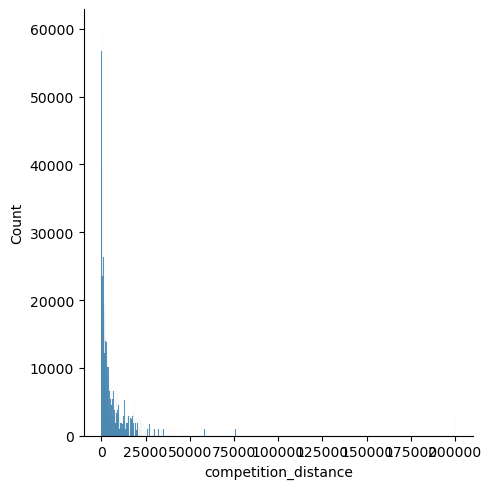

In [16]:
sns.displot(df1['competition_distance'], kde=False)
plt.show()

## 1.7.2 Categorical Atributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

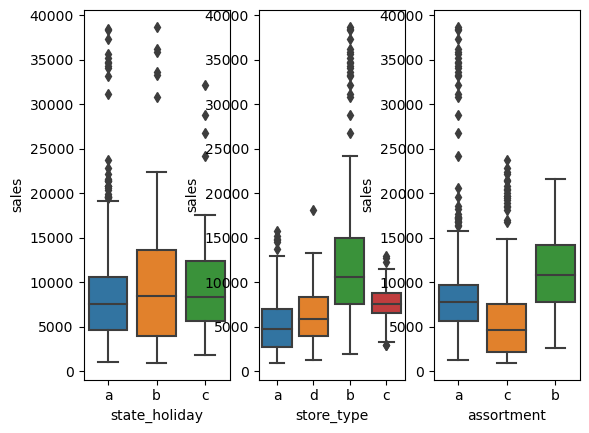

In [18]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

plt.show()

 ## 2.0 - Feature Engineering

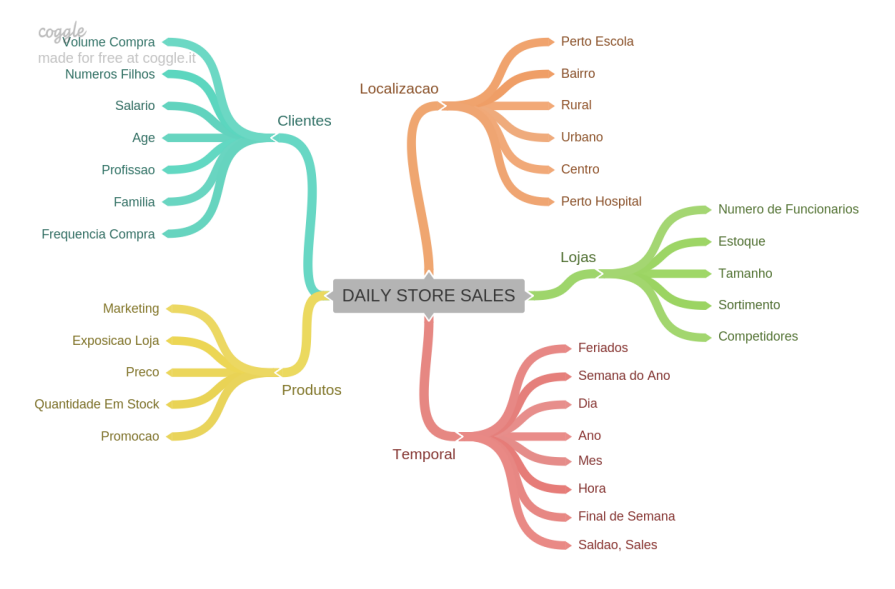

In [19]:
Image ("Images/MindMap.png")

## 2.2. Creating Hypotheses

In [20]:
df2 = df1.copy()

## 2.2.1. Hipoteses Loja

#### 1. Lojas com número maior de funcionários deveriam vender mais.
#### 2. Lojas com maior capacidade de estoque deveriam vender mais.
#### 3. Lojas com maior porte deveriam vender mais.
#### 4. Lojas com maior sortimentos deveriam vender mais.
#### 5. Lojas com competidores mais próximos deveriam vender menos.
#### 6. Lojas com competidores à mais tempo deveriam vendem mais.

## 2.2.2. Hipoteses Produto

#### 1. Lojas que investem mais em Marketing deveriam vender mais.
#### 2. Lojas com maior exposição de produto deveriam vender mais.
#### 3. Lojas com produtos com preço menor deveriam vender mais.
#### 5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
#### 6. Lojas com promoções ativas por mais tempo deveriam vender mais.
#### 7. Lojas com mais dias de promoção deveriam vender mais.
#### 8. Lojas com mais promoções consecutivas deveriam vender mais.

## 2.2.3. Hipoteses Tempo

#### 1. Lojas abertas durante o feriado de Natal deveriam vender mais.
#### 2. Lojas deveriam vender mais ao longo dos anos.
#### 3. Lojas deveriam vender mais no segundo semestre do ano.
#### 4. Lojas deveriam vender mais depois do dia 10 de cada mês.
#### 5. Lojas deveriam vender menos aos finais de semana.
#### 6. Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

#### 1. Lojas com maior sortimentos deveriam vender mais.
#### 2. Lojas com competidores mais próximos deveriam vender menos.
#### 3. Lojas com competidores à mais tempo deveriam vendem mais.
#### 4. Lojas com promoções ativas por mais tempo deveriam vender mais.
#### 5. Lojas com mais dias de promoção deveriam vender mais.
#### 7. Lojas com mais promoções consecutivas deveriam vender mais.
#### 8. Lojas abertas durante o feriado de Natal deveriam vender mais.
#### 9. Lojas deveriam vender mais ao longo dos anos.
#### 10. Lojas deveriam vender mais no segundo semestre do ano.
#### 11. Lojas deveriam vender mais depois do dia 10 de cada mês.
#### 12. Lojas deveriam vender menos aos finais de semana.
#### 13. Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [21]:
# year
df2["year"] = df2["date"].dt.year

# month
df2["month"] = df2["date"].dt.month

# day
df2["day"] = df2["date"].dt.day

# week of year
# df2["week_of_year"] = df2["date"].dt.weekofyear obsoleto
df2["week_of_year"] = df2["date"].dt.isocalendar().week

# year week
df2["year_week"] = df2["date"].dt.strftime ("%Y-%W")


# competition since 
df2["competition_since"] = df2.apply (lambda x: datetime.datetime (year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1), axis=1)
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) /30).apply ( lambda x: x.days).astype (int)

# promo since
df2["promo_since"] = df2["promo2_since_year"].astype (str) + "-" + df2["promo2_since_week"].astype (str)
df2["promo_since"] = df2["promo_since"].apply (lambda x: datetime.datetime.strptime (x + "-1", "%Y-%W-%w") - datetime.timedelta (days=7))
#.strptime(): Isso é um método da classe datetime que converte uma string em um objeto de data e hora.
df2["promo_time_week"] = ( ( df2["date"] - df2["promo_since"] )/7 ).apply(lambda x: x.days ).astype (int)

# assortment
df2["assortment"] = df2["assortment"].apply (lambda x: "basic" if x == "a" else"extra" if x == "b" else "extended")

# state holiday
df2["state_holiday"] = df2["state_holiday"].apply (lambda x: "public_holiday" if x == "a" else "easter_holiday" if x == "b" else "christmas" if x == "c" else "regular_day")


In [22]:
df2["week_of_year"] = df2["week_of_year"].astype (int)

In [23]:
df2.sample(5).T

,905454,603834,995695,241299,637173
store,860,290,786,300,179
day_of_week,4,1,7,5,6
date,2013-04-11 00:00:00,2014-01-06 00:00:00,2013-01-20 00:00:00,2014-12-26 00:00:00,2013-12-07 00:00:00
sales,5003,10714,0,0,7468
customers,637,884,0,0,1032
open,1,1,0,0,1
promo,1,1,0,0,0
state_holiday,regular_day,regular_day,regular_day,christmas,regular_day
school_holiday,0,1,0,1,0
store_type,c,a,a,a,a


## 3.0 - Filtering of Variables

In [24]:
df3 = df2.copy()

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Row Filtering

In [26]:
# Filtrei apenas o dias que estavam abertos, portanto != 0 e dias que teve vendas > 0
df3 = df3[(df3["open"] != 0) & (df3["sales"] > 0)]

## 3.2. Column Selection

In [27]:
# Não teria como saber qtos clientes teria na loja (customers), "promo_interval" e "month_map" eram colunas auxiliares.
cols_drop = ["customers", "open", "promo_interval", "month_map"]
df3 = df3.drop( cols_drop, axis=1 )